In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommend system /ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommend system /ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'Genres'], engine='python', encoding='latin-1')
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommend system /ml-1m/users.dat', sep='::', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')

movie_rating = pd.merge(ratings, movies, on = 'MovieID', how = 'left')


In [6]:
# matrix of user and movie rating
user_movie_matrix = movie_rating.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
print(user_movie_matrix)

MovieID  1     2     3     4     5     6     7     8     9     10    ...  \
UserID                                                               ...   
1         5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
6036      0.0   0.0   0.0   2.0   0.0   3.0   0.0   0.0   0.0   0.0  ...   
6037      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6038      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6039      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6040      3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

MovieID  39

# Collaborative filtering


## ALS

In [19]:
!pip install implicit

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Convert the user-movie matrix to a sparse matrix
user_movie_matrix_sparse = csr_matrix(user_movie_matrix.values)

# Split the data into training and testing sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create a training user-item matrix
train_matrix = train_data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
train_matrix_sparse = csr_matrix(train_matrix.values)

# Train the ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.02, iterations=25)
model.fit(train_matrix_sparse)

# Create a test user-item matrix
test_matrix = test_data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
test_matrix_sparse = csr_matrix(test_matrix.values)

# Make predictions for the test set
user_ids = test_data['UserID'].values
movie_ids = test_data['MovieID'].values
predictions = []

for user_id, movie_id in zip(user_ids, movie_ids):
    try:  # Try to get predictions, if user or item not in training data, skip.
        user_index = train_matrix.index.get_loc(user_id) # Get index from training matrix index
        movie_index = train_matrix.columns.get_loc(movie_id) # Get index from training matrix columns
        pred = model.user_factors[user_index] @ model.item_factors[movie_index].T
        predictions.append(pred)
    except KeyError:  # Handle KeyError if user or item not found in training data
        #print(f"User {user_id} or Movie {movie_id} not in training data. Skipping...")
        continue  # Skip to the next iteration


# Calculate MSE and RMSE
true_ratings = test_data['Rating'].values
# Filter true_ratings to align with predictions after skipping some values
true_ratings = [true_ratings[i] for i in range(len(true_ratings)) if i < len(predictions)]

mse = mean_squared_error(true_ratings, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

  0%|          | 0/25 [00:00<?, ?it/s]

MSE: 10.589708549506312
RMSE: 3.2541832384649627


## SVD

In [21]:
!pip install scikit-surprise

import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


# Define the rating scale (minimum and maximum rating)
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset into the Surprise format
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Train the SVD model
model = SVD(n_factors=50, n_epochs=25, lr_all=0.007, reg_all=0.03)
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Calculate MSE and RMSE
mse = accuracy.mse(predictions)
rmse = accuracy.rmse(predictions)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 0.7474
RMSE: 0.8645
MSE: 0.7474206047348392
RMSE: 0.8645349066028735


In [22]:
from collections import defaultdict
# Function to get top N recommendations for a user
def get_top_n_recommendations(predictions, user_id, n=10):
    # Map predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort predictions for the user and get the top N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n[user_id]

# Generate predictions for the test set
testset = trainset.build_anti_testset()  # Predict ratings for movies not rated by users
predictions = model.test(testset)

# Get top 10 recommendations for a specific user (e.g., user_id = 1)
user_id = 1
top_n_recommendations = get_top_n_recommendations(predictions, user_id, n=10)

# Display the recommended movies
print(f"Top 10 recommendations for user {user_id}:")
for movie_id, estimated_rating in top_n_recommendations:
    movie_title = movies[movies['MovieID'] == movie_id]['Title'].values[0]
    print(f"Movie: {movie_title} | Estimated Rating: {estimated_rating:.2f}")

Top 10 recommendations for user 1:
Movie: Shawshank Redemption, The (1994) | Estimated Rating: 4.89
Movie: Sanjuro (1962) | Estimated Rating: 4.87
Movie: Inherit the Wind (1960) | Estimated Rating: 4.77
Movie: Bridge on the River Kwai, The (1957) | Estimated Rating: 4.73
Movie: Silence of the Lambs, The (1991) | Estimated Rating: 4.72
Movie: Cinema Paradiso (1988) | Estimated Rating: 4.72
Movie: Rear Window (1954) | Estimated Rating: 4.67
Movie: Life Is Beautiful (La Vita è bella) (1997) | Estimated Rating: 4.66
Movie: Cold Fever (Á köldum klaka) (1994) | Estimated Rating: 4.66
Movie: American History X (1998) | Estimated Rating: 4.65


# Content-base filtering

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# Preprocess the genres column
# Combine genres into a single string for each movie
movies['Genres'] = movies['Genres'].apply(lambda x: x.replace('|', ' '))

# Use TF-IDF Vectorizer to convert genres into feature vectors
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])

# Compute cosine similarity between movies
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on content similarity
def get_content_based_recommendations(movie_title, cosine_sim=cosine_sim, top_n=10):
    # Get the index of the movie
    idx = movies[movies['Title'] == movie_title].index[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top N most similar movies (excluding itself)
    sim_scores = sim_scores[1:top_n + 1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top N similar movies
    return movies['Title'].iloc[movie_indices]

# Example: Get recommendations for a specific movie
movie_title = 'Toy Story (1995)'
recommendations = get_content_based_recommendations(movie_title)
print(f"Top 10 recommendations for '{movie_title}':")
print(recommendations)

Top 10 recommendations for 'Toy Story (1995)':
1050            Aladdin and the King of Thieves (1996)
2072                          American Tail, An (1986)
2073        American Tail: Fievel Goes West, An (1991)
2285                         Rugrats Movie, The (1998)
2286                              Bug's Life, A (1998)
3045                                Toy Story 2 (1999)
3542                             Saludos Amigos (1943)
3682                                Chicken Run (2000)
3685    Adventures of Rocky and Bullwinkle, The (2000)
12                                        Balto (1995)
Name: Title, dtype: object


# Unsupervised learning

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Standardlize data
scaler = StandardScaler()
user_movie_matrix_scaled = scaler.fit_transform(user_movie_matrix.rename(columns=str))

## K-Means clustering

    UserID  Cluster
0        1        4
1        2        4
2        3        4
3        4        4
4        5        4
5        6        4
6        7        4
7        8        4
8        9        4
9       10        1
10      11        4
11      12        4
12      13        4
13      14        4
14      15        4
15      16        4
16      17        4
17      18        1
18      19        1
19      20        4
  MovieID  Cluster
0       1        0
1       2        0
2       3        4
3       4        4
4       5        4


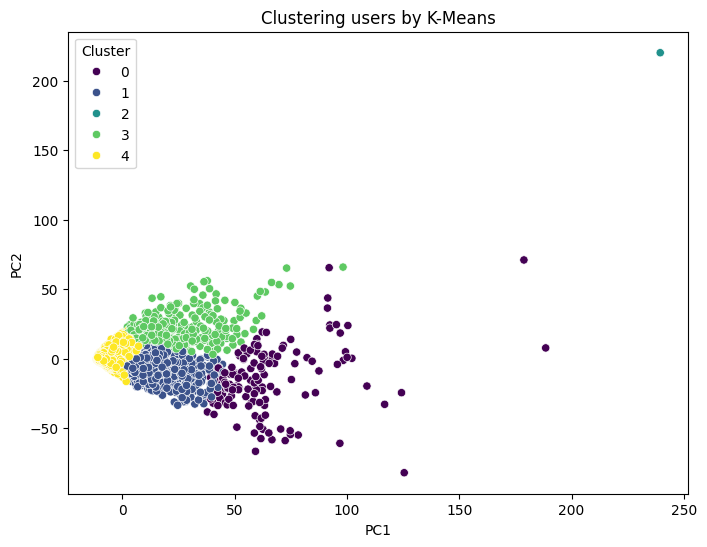

In [28]:
# User clustering
# K-Means
num_clusters = 5
kmeans_users = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
user_clusters = kmeans_users.fit_predict(user_movie_matrix_scaled)

# Add column to data frame
user_clusters_df = pd.DataFrame({'UserID': user_movie_matrix.index, 'Cluster': user_clusters})
print(user_clusters_df.head(20))


# Movie clustering
# Movie-user matrix
movie_user_matrix = user_movie_matrix.T
movie_user_matrix_scaled = scaler.fit_transform(movie_user_matrix)

# K-Means
kmeans_movies = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
movie_clusters = kmeans_movies.fit_predict(movie_user_matrix_scaled)

# Add column to data frame
movie_clusters_df = pd.DataFrame({'MovieID': movie_user_matrix.index, 'Cluster': movie_clusters})
print(movie_clusters_df.head())

# reduce dimensionality
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_movie_matrix_scaled)

# Convert to data frame
user_pca_df = pd.DataFrame(user_pca, columns=['PC1', 'PC2'])
user_pca_df['Cluster'] = user_clusters

# Scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=user_pca_df, palette='viridis')
plt.title('Clustering users by K-Means')
plt.show()

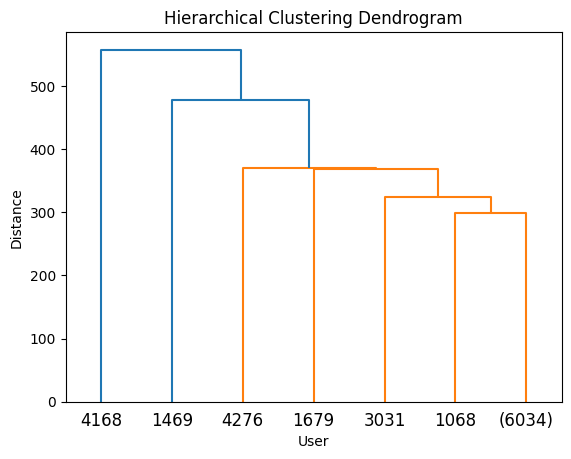

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

mergings = linkage(user_movie_matrix_scaled, method='average')
dendrogram(mergings, truncate_mode = 'level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('User')
plt.ylabel('Distance')
plt.show()

In [15]:
num_clusters = 5
user_clusters = fcluster(mergings, num_clusters, criterion = 'maxclust')
user_clusters_df = pd.DataFrame({'UserID' : user_movie_matrix.index, 'Cluster': user_clusters})
print(user_clusters_df.head())


    UserID  Cluster
0        1        1
1        2        1
2        3        1
3        4        1
4        5        1
5        6        1
6        7        1
7        8        1
8        9        1
9       10        2
10      11        1
11      12        1
12      13        2
13      14        1
14      15        1
15      16        1
16      17        2
17      18        2
18      19        2
19      20        1
20      21        1
21      22        2
22      23        2
23      24        1
24      25        1
25      26        2
26      27        1
27      28        1
28      29        1
29      30        1
30      31        1
31      32        1
32      33        2
33      34        1
34      35        1
35      36        2
36      37        1
37      38        1
38      39        1
39      40        1
40      41        1
41      42        2
42      43        1
43      44        2
44      45        2
45      46        2
46      47        1
47      48        2
48      49        1


cluster
 0     4001
-1     1535
 5       58
 10      52
 7       30
 9       24
 4       22
 6       16
 24      15
 11      15
 15      13
 32      13
 26      10
 1       10
 18      10
 13       9
 19       8
 34       8
 2        8
 16       8
 40       7
 44       7
 12       7
 30       7
 45       7
 17       7
 29       7
 28       7
 38       6
 47       6
 21       6
 39       6
 3        6
 25       6
 27       6
 42       6
 36       5
 48       5
 37       5
 33       5
 14       5
 46       5
 31       5
 35       5
 23       5
 22       5
 20       5
 8        5
 41       4
 49       4
 43       3
Name: count, dtype: int64


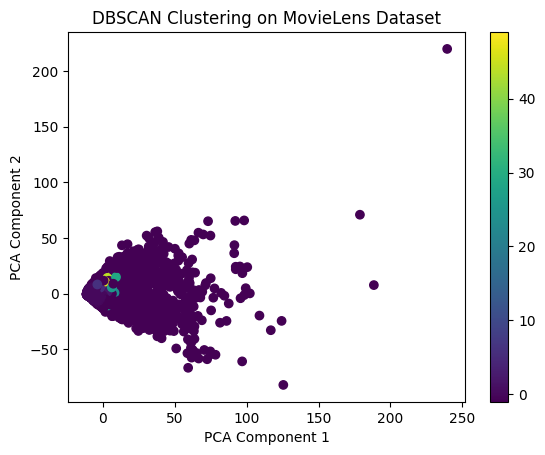

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fill NaN values with 0 (indicating no rating)
user_movie_matrix = user_movie_matrix.fillna(0)

# Standardize the data (important for DBSCAN)
scaler = StandardScaler()
user_movie_matrix_scaled = scaler.fit_transform(user_movie_matrix)

# Apply PCA to reduce dimensionality (optional but recommended for high-dimensional data)
pca = PCA(n_components=2)
user_movie_matrix_pca = pca.fit_transform(user_movie_matrix_scaled)

# Run DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(user_movie_matrix_pca)

# Add cluster labels to the original user-item matrix
user_movie_matrix['cluster'] = clusters

# Analyze the results
print(user_movie_matrix['cluster'].value_counts())

# Visualize the clusters
plt.scatter(user_movie_matrix_pca[:, 0], user_movie_matrix_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering on MovieLens Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()